# Genetic algorithm

- In this juptyer notebook, we apply `Genetic Algorithm` on fitting Neural Network model instead of using *gradient descent* to fit the model.
    
    + Each model is represented by a fixed-length list of parameters.

    + A population of neural network models are initlized without further training.

    + *Crossover* is performed as usual by swapping paramters between 2 models.

    + *Mutation*, however, since it is string of float numbers (not bits) we can not do flipping as normal. Instead, we add a random noise with some probability to chosen parameter.

## Step 1: import necessary libraries

In [34]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import Dataset
from tqdm import tqdm
import os
import sys
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))

from data import Preprocessing, FeatureExtraction

## Step 2: Preprocessing

In [2]:
prepro = Preprocessing()
train_df = prepro.read_CSV("train.csv")
test_df = prepro.read_CSV("test.csv")
train_df.shape, test_df.shape

((27480, 10), (3534, 9))

In [3]:
train_data = Dataset.from_pandas(train_df)
test_data = Dataset.from_pandas(test_df)
train_data[0]

{'textID': 'cb774db0d1',
 'text': ' I`d have responded, if I were going',
 'selected_text': 'I`d have responded, if I were going',
 'sentiment': 'neutral',
 'Time of Tweet': 'morning',
 'Age of User': '0-20',
 'Country': 'Afghanistan',
 'Population -2020': 38928346,
 'Land Area (Km²)': 652860.0,
 'Density (P/Km²)': 60,
 '__index_level_0__': 0}

In [4]:
train_data = train_data.map(lambda ex: {'processed_text': prepro.preprocess(ex['text']),\
                                        'label': 2 if ex['sentiment'] == 'positive' else \
                                        1 if ex['sentiment'] == 'neutral' else 0 })
test_data = test_data.map(lambda ex: {'processed_text': prepro.preprocess(ex['text']),\
                                        'label': 2 if ex['sentiment'] == 'positive' else \
                                        1 if ex['sentiment'] == 'neutral' else 0 })

train_data[0]

Map:   0%|          | 0/27480 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

{'textID': 'cb774db0d1',
 'text': ' I`d have responded, if I were going',
 'selected_text': 'I`d have responded, if I were going',
 'sentiment': 'neutral',
 'Time of Tweet': 'morning',
 'Age of User': '0-20',
 'Country': 'Afghanistan',
 'Population -2020': 38928346,
 'Land Area (Km²)': 652860.0,
 'Density (P/Km²)': 60,
 '__index_level_0__': 0,
 'processed_text': 'id responded going',
 'label': 1}

### Visualize the number of samples for each class

/var/folders/cy/hxjg9r351_99ytx8k04pq_4c0000gn/T/ipykernel_925/3149057442.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


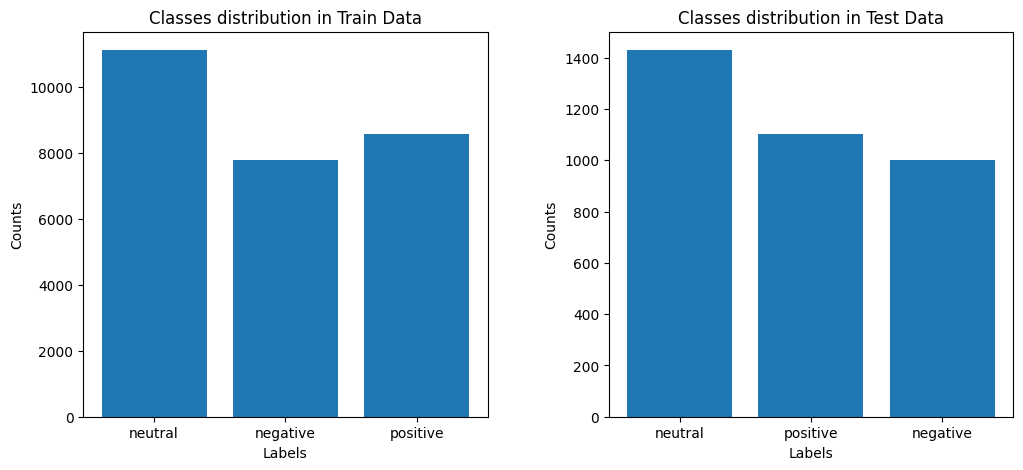

In [5]:
from typing import Counter
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'wspace': 0.3})

counter = Counter(train_data['sentiment'])
axs[0].bar(counter.keys(), counter.values())
axs[0].set_title("Classes distribution in Train Data")
axs[0].set_xlabel("Labels")
axs[0].set_ylabel("Counts")

counter = Counter(test_data['sentiment'])
axs[1].bar(counter.keys(), counter.values())
axs[1].set_title("Classes distribution in Test Data")
axs[1].set_xlabel("Labels")
axs[1].set_ylabel("Counts")

plt.tight_layout()
plt.show()

### Map tf-idf features for each

In [6]:
extractor = TfidfVectorizer(ngram_range=(1,3), max_features=1000)
extractor.fit(train_data['processed_text'])
train_tf_idf_feature = extractor.transform(train_data['processed_text']).toarray()
test_tf_idf_feature = extractor.transform(test_data['processed_text']).toarray()

print(f"train tf-idf shape: ({len(train_tf_idf_feature)}, {len(train_tf_idf_feature[0])})")
print(f"test tf-idf shape: ({len(test_tf_idf_feature)}, {len(test_tf_idf_feature[0])})")

def add_tf_idf(example, idx, tf_idf_feature):
    return {'tf_idf': tf_idf_feature[idx]}

train_data = train_data.map(add_tf_idf, with_indices=True, fn_kwargs={'tf_idf_feature': train_tf_idf_feature})
test_data = test_data.map(add_tf_idf, with_indices=True, fn_kwargs={'tf_idf_feature': test_tf_idf_feature})
train_data[0]

train tf-idf shape: (27480, 1000)
test tf-idf shape: (3534, 1000)


Map:   0%|          | 0/27480 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

{'textID': 'cb774db0d1',
 'text': ' I`d have responded, if I were going',
 'selected_text': 'I`d have responded, if I were going',
 'sentiment': 'neutral',
 'Time of Tweet': 'morning',
 'Age of User': '0-20',
 'Country': 'Afghanistan',
 'Population -2020': 38928346,
 'Land Area (Km²)': 652860.0,
 'Density (P/Km²)': 60,
 '__index_level_0__': 0,
 'processed_text': 'id responded going',
 'label': 1,
 'tf_idf': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")
train_data.set_format(type="torch", columns=['tf_idf', 'label'])
test_data.set_format(type="torch", columns=['tf_idf', 'label'])
train_data[0]

device: cpu


{'label': tensor(1),
 'tf_idf': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

### Split train data into train and validation sets

In [8]:
train_dict = Dataset.train_test_split(train_data, test_size=0.2, shuffle=True, seed=2025)
train_data = train_dict['train']
valid_data = train_dict['test']

train_data.shape, valid_data.shape, test_data.shape

((21984, 14), (5496, 14), (3534, 13))

In [9]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=True)

print(f"Number of train batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")
print(f"Number of valid batches: {len(valid_loader)}")

Number of train batches: 687
Number of test batches: 111
Number of valid batches: 172


## Step 3: Build model

In [10]:
class NeuralModel(nn.Module):
    def __init__(self, input_size, hidden_size=10, output_size=3):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.layer2 = nn.Linear(in_features=hidden_size, out_features=output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.sigmoid(self.layer1(x))
        x = self.softmax(self.layer2(x))
        return x

In [11]:
def encode_weights(model):
    """Flatten the weights of the model into a chromosome."""
    return torch.cat([p.view(-1) for p in model.parameters()])

def decode_weights(model, weights):
    """Reshape a chromosome into model weights."""

    with torch.no_grad():
        index = 0

        for param in model.parameters():
            num_params = param.numel()
            param.copy_(weights[index:index+num_params].view(param.shape))
            index += num_params

In [12]:
def initialize_population(pop_size, input_size, device="cpu", start_seed=2025):
    """
    Intialize a population of neural networks
    """
    population = []
    for i in range(pop_size):
        torch.manual_seed(start_seed+i)
        new_model = NeuralModel(input_size).to(device)
        weights = encode_weights(new_model) # convert model to sequence of gens
        population.append(weights)
    
    return population

In [13]:
def accuracy_eval(outputs, labels):
    predictions = np.argmax(outputs, axis=1)
    return accuracy_score(labels, predictions)

def f1_eval(outputs, labels):
    predictions = np.argmax(outputs, axis=1)
    return f1_score(labels, predictions, average='weighted')

def fitness(weights, model, loader, name, show_progress=False):
    decode_weights(model, weights)
    model.eval()
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        progress = tqdm(loader, desc=f"Evaluating on {name.lower()} data") if show_progress else loader

        for batch in progress:
            input = batch['tf_idf'].to(device)
            label = batch['label'].to(device)
            output = model(input)

            all_outputs.extend(output.detach().cpu().numpy())
            all_labels.extend(label.detach().cpu().numpy())
    
    return f1_eval(all_outputs, all_labels)

input_size = len(train_data[0]['tf_idf'])
model = NeuralModel(input_size, hidden_size=10)
weights = encode_weights(model)
fitness(weights, model, train_loader, "train")

0.14892403294789108

In [14]:
def model_selection(population, fitness_score, parents_size=2):
    probabilities = fitness_score / (fitness_score.sum() + 1e-8)

    indices = torch.multinomial(probabilities, num_samples=parents_size, replacement=True)

    return [population[i] for i in indices.tolist()]

In [15]:
def crossover(parent_1, parent_2, device="cpu"):
    mask = torch.randint(low=0, high=2, size=(len(parent_1),), dtype=torch.bool).to(device)
    child_1 = torch.where(mask, parent_1, parent_2)
    child_2 = torch.where(mask, parent_2, parent_1)

    return child_1, child_2

In [16]:
def mutation(weights, mutation_rate=0.05, noise=0.1):
    total_params = len(weights)
    mutation_num = int(mutation_rate * total_params)
    mutation_indices = np.random.randint(low=0, high=total_params, size=mutation_num)

    for idx in mutation_indices:
        weights[idx] += (2*torch.rand(1) - 1).squeeze()

    return weights

### Define hyperparameter list

In [17]:
MAX_FEATURES = 500
GENERATIONS = 10

POPULATION_SIZE = 10
MUTATION_RATE = 0.2
MUTATION_NOISE = 0.2

In [18]:
class GeneticModel:
    def __init__(self, pop_size, shape, mut_rate = MUTATION_RATE, mut_noise = MUTATION_NOISE):
        self.population = initialize_population(pop_size, shape, device=device)
        self.model = NeuralModel(shape).to(device)
        self.mutation_rate = mut_rate
        self.mutation_noise = mut_noise

        self.pop_size = pop_size
        self.best_weights = None            # No fitting => No best weights
    
    def fit(self, loader, epochs=GENERATIONS):
        for _ in tqdm(range(epochs), desc="Evolving Generations"):
            print(f"Step 1: Computing fitness score")
            fitness_scores = torch.tensor([fitness(weights, self.model, loader, "")
                                           for weights in self.population])
            
            # Generate new population
            print(f"Step 2: Generating new models")
            new_population = []
            for idx, _ in enumerate(range(self.pop_size // 2)):
                parents = model_selection(self.population, fitness_scores)
                child1, child2 = crossover(parents[0], parents[1], device=device)
                new_population.append(mutation(child1, mutation_rate=self.mutation_rate, noise=self.mutation_noise))
                new_population.append(mutation(child2, mutation_rate=self.mutation_rate, noise=self.mutation_noise))

            self.population = new_population
        
        self.best_weights = self.population[np.argmax(fitness_scores)]
        decode_weights(self.model, self.best_weights)


    def predict(self, input):
        self.model.eval()
        with torch.no_grad():
            return self.model(input)

In [19]:
from visualization import *
from hyperparameter_tunning import *
from IPython.display import clear_output

tunning_params = [
    IntVariableSuggestion("pop_size", 10, 20),
    FloatVariableSuggestion("mut_rate", 0.05, 0.9),
    FloatVariableSuggestion("mut_noise", 0.05, 0.9)
]

def training_func(loader, pop_size, mut_rate, mut_noise):
    # clear_output(wait=True)
    genetic_model = GeneticModel(pop_size, input_size, mut_rate, mut_noise)

    genetic_model.fit(loader, 5)
    return genetic_model

def evaluation_func(genetic_model, loader, pop_size, mut_rate, mut_noise):
    all_outputs = []
    all_labels = []

    for batch in tqdm(loader):
        input = batch['tf_idf'].to(device)
        label = batch['label'].to(device)
        output = genetic_model.predict(input)

        all_outputs.extend(output.detach().cpu().numpy())
        all_labels.extend(label.detach().cpu().numpy())
    
    return f1_eval(all_outputs, all_labels)

tunning_model = Tunning(tunning_params, training_func, evaluation_func)
study = tunning_model.tunning(train_loader, valid_loader, n_trials=15, direction='maximize', timeout=600)

[I 2025-05-18 09:15:41,928] A new study created in memory with name: no-name-9412972f-3772-4971-be2b-27b62bc757a3
Evolving Generations:   0%|          | 0/5 [00:00<?, ?it/s]

Step 1: Computing fitness score
Step 2: Generating new models


Evolving Generations:  20%|██        | 1/5 [00:37<02:31, 37.85s/it]

Step 1: Computing fitness score
Step 2: Generating new models


Evolving Generations:  40%|████      | 2/5 [01:23<02:06, 42.15s/it]

Step 1: Computing fitness score
Step 2: Generating new models


Evolving Generations:  60%|██████    | 3/5 [02:00<01:19, 39.88s/it]

Step 1: Computing fitness score
Step 2: Generating new models


Evolving Generations:  80%|████████  | 4/5 [02:39<00:39, 39.51s/it]

Step 1: Computing fitness score
Step 2: Generating new models


100%|██████████| 172/172 [00:00<00:00, 464.00it/s]
[I 2025-05-18 09:18:59,273] Trial 0 finished with value: 0.12365188463367036 and parameters: {'pop_size': 16, 'mut_rate': 0.6524478842693392, 'mut_noise': 0.26504768924566635}. Best is trial 0 with value: 0.12365188463367036.
Evolving Generations:   0%|          | 0/5 [00:00<?, ?it/s]

Step 1: Computing fitness score
Step 2: Generating new models


Evolving Generations:  20%|██        | 1/5 [00:31<02:07, 31.92s/it]

Step 1: Computing fitness score
Step 2: Generating new models


Evolving Generations:  40%|████      | 2/5 [01:02<01:33, 31.01s/it]

Step 1: Computing fitness score
Step 2: Generating new models


Evolving Generations:  60%|██████    | 3/5 [01:33<01:02, 31.27s/it]

Step 1: Computing fitness score
Step 2: Generating new models


Evolving Generations:  80%|████████  | 4/5 [02:09<00:32, 32.87s/it]

Step 1: Computing fitness score
Step 2: Generating new models


100%|██████████| 172/172 [00:00<00:00, 533.92it/s]
[I 2025-05-18 09:21:40,868] Trial 1 finished with value: 0.32022358395019196 and parameters: {'pop_size': 14, 'mut_rate': 0.505462319364067, 'mut_noise': 0.8150838124025976}. Best is trial 1 with value: 0.32022358395019196.
Evolving Generations:   0%|          | 0/5 [00:00<?, ?it/s]

Step 1: Computing fitness score
Step 2: Generating new models


Evolving Generations:  20%|██        | 1/5 [00:28<01:53, 28.27s/it]

Step 1: Computing fitness score
Step 2: Generating new models


Evolving Generations:  40%|████      | 2/5 [00:58<01:27, 29.22s/it]

Step 1: Computing fitness score
Step 2: Generating new models


Evolving Generations:  60%|██████    | 3/5 [01:29<01:00, 30.15s/it]

Step 1: Computing fitness score
Step 2: Generating new models


Evolving Generations:  80%|████████  | 4/5 [02:02<00:31, 31.26s/it]

Step 1: Computing fitness score
Step 2: Generating new models


100%|██████████| 172/172 [00:00<00:00, 537.11it/s]
[I 2025-05-18 09:24:16,155] Trial 2 finished with value: 0.15098261224222584 and parameters: {'pop_size': 14, 'mut_rate': 0.30758045404047213, 'mut_noise': 0.18966564882965992}. Best is trial 1 with value: 0.32022358395019196.
Evolving Generations:   0%|          | 0/5 [00:00<?, ?it/s]

Step 1: Computing fitness score
Step 2: Generating new models


Evolving Generations:  20%|██        | 1/5 [00:38<02:32, 38.22s/it]

Step 1: Computing fitness score
Step 2: Generating new models


Evolving Generations:  40%|████      | 2/5 [01:15<01:53, 37.94s/it]

Step 1: Computing fitness score
Step 2: Generating new models


Evolving Generations:  60%|██████    | 3/5 [01:51<01:13, 37.00s/it]

Step 1: Computing fitness score
Step 2: Generating new models


Evolving Generations:  80%|████████  | 4/5 [02:26<00:35, 35.89s/it]

Step 1: Computing fitness score
Step 2: Generating new models


100%|██████████| 172/172 [00:00<00:00, 507.75it/s]
[I 2025-05-18 09:27:16,812] Trial 3 finished with value: 0.14902222636455648 and parameters: {'pop_size': 16, 'mut_rate': 0.3257097194234484, 'mut_noise': 0.24021319324365153}. Best is trial 1 with value: 0.32022358395019196.


### Get best hyperparameters

In [20]:
print(f'Best params = {study.best_params}')

tunning_population_size = study.best_params['pop_size']
tunning_mutation_rate = study.best_params['mut_rate']
tunning_mutation_noise = study.best_params['mut_noise']

Best params = {'pop_size': 14, 'mut_rate': 0.505462319364067, 'mut_noise': 0.8150838124025976}


In [22]:
# Genetic Algorithm Parameters
population = initialize_population(tunning_population_size, input_size, device=device)
model = NeuralModel(input_size).to(device)

for generation in tqdm(range(GENERATIONS), desc="Evolving Generations"):
    # compute fitness scores of current population
    fitness_scores = torch.tensor([fitness(weights, model, train_loader, "train", show_progress=False) for weights in population])

    # Generate new population
    new_population = []
    for _ in range(tunning_population_size // 2):
        parents = model_selection(population, fitness_scores)
        child1, child2 = crossover(parents[0], parents[1], device=device)
        new_population.append(mutation(child1, mutation_rate=tunning_mutation_rate, noise=tunning_mutation_noise))
        new_population.append(mutation(child2, mutation_rate=tunning_mutation_rate, noise=tunning_mutation_noise))

    population = new_population

best_weights = population[np.argmax(fitness_scores)]
decode_weights(model, best_weights)
final_acc = fitness(best_weights, model, test_loader, "test", show_progress=True)
train_acc = fitness(best_weights, model, train_loader, "train", show_progress=True)

print(f"Final Accuracy on Test Set: {final_acc:.4f}")
print(f"Final Accuracy on Train Set: {train_acc:.4f}")

Evolving Generations:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating on train data: 100%|██████████| 687/687 [00:01<00:00, 535.46it/s]

Final Accuracy on Test Set: 0.1511
Final Accuracy on Train Set: 0.1508


## Step 4: Model evaluation

Evaluating: 100%|██████████| 111/111 [00:00<00:00, 617.61it/s]


f1-score (macro) = 0.1510521303774568


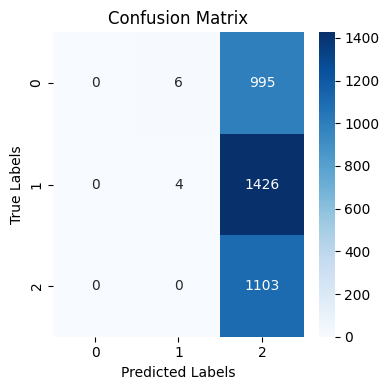

In [ ]:
model.eval()

with torch.no_grad():
    all_outputs = []
    all_labels = []

    for batch in tqdm(test_loader, desc="Evaluating"):
        input_data = batch['tf_idf'].to(device)
        label = batch['label'].to(device)
        output = model(input_data)

        all_outputs.extend(output.detach().cpu().numpy())
        all_labels.extend(label.detach().cpu().numpy())

    # print(f"all_outputs = {len(all_outputs)}")
    # print(f"all_labels = {len(all_labels)}")
    all_preds = np.argmax(all_outputs, axis=-1)

print(f"f1-score (macro) = {f1_score(all_labels, all_preds, average='weighted')}")

try:
    # Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.show()
except:
    print("Can not print confusion metric")

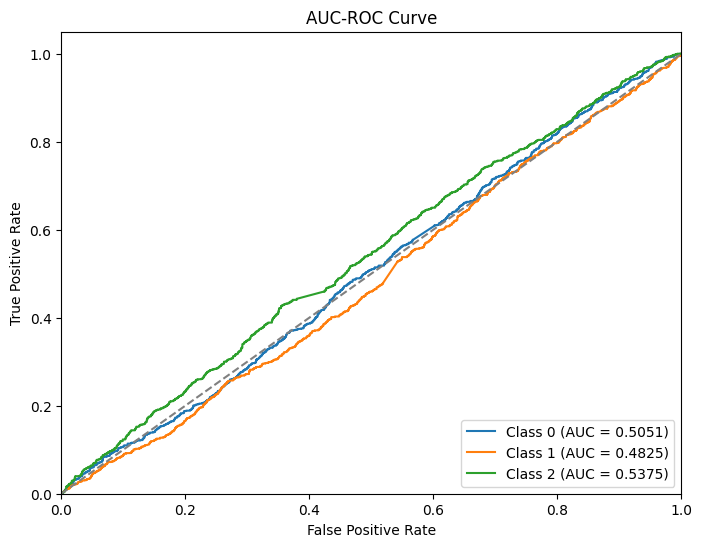

In [44]:
plot_roc_auc(all_labels, np.array(all_outputs), [0, 1, 2])